# Extractive Text Summarization Of Wikipedia Articles

In [1]:
import time

import re

import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
sw_set = set(stopwords.words("english"))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import deepcopy

In [2]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

In [3]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anytig between [] including []
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

In [4]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)

In [5]:
pp_string = (" ").join(pp_article_st)

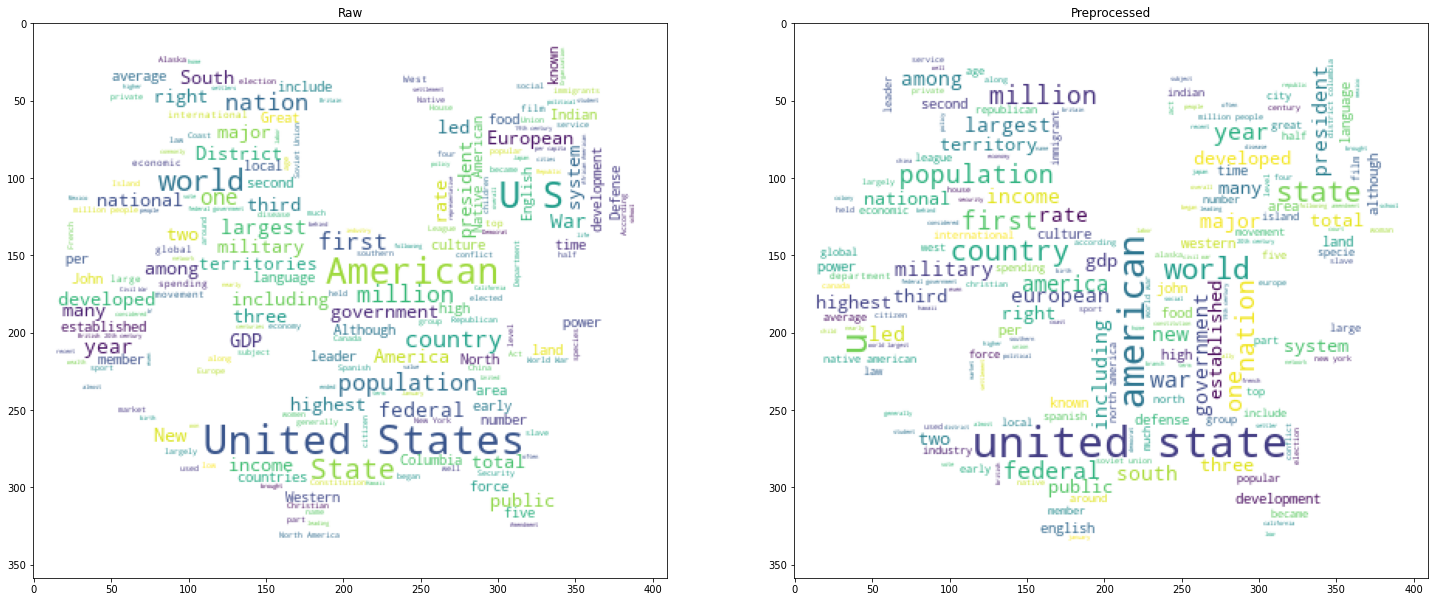

In [6]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

In [7]:
#define the summary length
#This could be also though of as number of 
#import topics to be used in the summary
N_LINE = 20

In [8]:
#1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)
count_vectorizer = CountVectorizer(ngram_range=(2,2)) 
count_vectorizer.fit(pp_article_st)
X = count_vectorizer.transform(pp_article_st)

In [9]:
#perform Latent Semantic Analysis (LSA)
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100)

In [10]:
U.shape #document-topic

(578, 20)

In [11]:
VT.shape #topic-term

(20, 6768)

In [12]:
SIGMA.shape # topic - topic sparse matrix

(20,)

In [13]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [14]:
scores.shape

(578,)

In [15]:
top_scores_index = np.argsort(scores)

In [16]:
top_scores_index[0:5]

array([ 37, 119, 502, 222, 428], dtype=int64)

In [17]:
article_array = np.array(article_st)

In [18]:
bow_sum = article_array[top_scores_index[0:N_LINE]]

In [19]:
bow_sum = list(bow_sum)

In [20]:
bow_sum = (" ").join(bow_sum)

In [21]:
bow_sum

'other common forms are the "u.s.", the "usa", and "america". reconstruction began in earnest following the war. "[466]\nthirteen u.s. citizens have won the nobel prize in literature. much of the western mountains have an alpine climate. [382] the u.s. dollar is the world\'s primary reserve currency. "[292] the u.s. ranked 25th on the democracy index in 2018. since the decision, however, there have been more than 1,500 executions. [243] these include judaism (1.9%), islam (0.9%), hinduism (0.7%), and buddhism (0.7%). [458] whether this perception is accurate has been a topic of debate. [271] however, the u.s. is a global leader in medical innovation. [278] the basic literacy rate is approximately 99%. they demanded their "rights as englishmen" and "no taxation without representation". they are subdivided into counties or county-equivalents and further divided into municipalities. [145]\nthe 1970s and early 1980s saw the onset of stagflation. [319] of state governors, there are 27 repub

In [22]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2)) #1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)
N_LINE = 20
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100)
scores = np.sqrt(np.dot(U**2,SIGMA**2))
top_scores_index = np.argsort(scores)
article_array = np.array(article_st)
tfidf_sum = list(article_array[top_scores_index[0:N_LINE]])
tfidf_sum = (" ").join(tfidf_sum)
tfidf_sum

"this further expanded acreage under mechanical cultivation, increasing surpluses for international markets. [114] the 1920s and 1930s saw the rise of radio for mass communication and the invention of early television. [242][244][245] membership in a house of worship fell from 70% in 1999 to 47% in 2020, much of the decline related to the number of americans expressing no religious preference. among the d.c. mayor and the five territorial governors, there are three democrats, one republican, and one new progressive. [32][33][34] the clovis culture, which appeared around 11,000 bc, is believed to represent the first wave of human settlement of the americas. [248] apart from baptists, other protestant categories include nondenominational protestants, methodists, pentecostals, unspecified protestants, lutherans, presbyterians, congregationalists, other reformed, episcopalians/anglicans, quakers, adventists, holiness, christian fundamentalists, anabaptists, pietists, and multiple others. [

In [23]:
from rouge_score import rouge_scorer

In [24]:
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False)

In [25]:
scorer.score(bow_sum,pp_string)

{'rouge2': Score(precision=0.004975124378109453, recall=0.18340611353711792, fmeasure=0.009687463960327528)}

In [26]:
scorer.score(tfidf_sum,pp_string)

{'rouge2': Score(precision=0.008884150675195452, recall=0.20491803278688525, fmeasure=0.0170299727520436)}